In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import os
import random

## Supressing warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=28b7312fd2c3743f95c29110b9d1bb3e349f0c65500633b867f7aa09fd7872e1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
## importing essential spark libraries:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, count, when, regexp_replace, udf, struct, lit, isnull, trim, asc, desc, round, mean, abs, concat
from pyspark.sql.functions import to_timestamp, to_date, unix_timestamp, date_format, hour   ### --> Date manipulation
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [4]:
##  Creating a Spark session:
spark = SparkSession.builder.appName('FoodDelivery').getOrCreate()

In [5]:
df=spark.read.csv("FoodDelivery.csv",
                  header=True,
                  inferSchema=True)

## Displaying the first 5 rows:
df.toPandas().head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,2024-05-21 11:45:00,conditions Sunny,High,2,Snack,motorcycle,0.0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,2024-05-21 19:50:00,conditions Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,2024-05-21 08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,2024-05-21 18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,2024-05-21 13:45:00,conditions Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,(min) 30


In [6]:
## Printing the attributes of the table:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Delivery_person_ID: string (nullable = true)
 |-- Delivery_person_Age: double (nullable = true)
 |-- Delivery_person_Ratings: double (nullable = true)
 |-- Restaurant_latitude: double (nullable = true)
 |-- Restaurant_longitude: double (nullable = true)
 |-- Delivery_location_latitude: double (nullable = true)
 |-- Delivery_location_longitude: double (nullable = true)
 |-- Order_Date: string (nullable = true)
 |-- Time_Orderd: string (nullable = true)
 |-- Time_Order_picked: timestamp (nullable = true)
 |-- Weatherconditions: string (nullable = true)
 |-- Road_traffic_density: string (nullable = true)
 |-- Vehicle_condition: integer (nullable = true)
 |-- Type_of_order: string (nullable = true)
 |-- Type_of_vehicle: string (nullable = true)
 |-- multiple_deliveries: double (nullable = true)
 |-- Festival: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Time_taken(min): string (nullable = true)



In [7]:
## Shape of the dataframe is:
df.count(),len(df.columns)

(45593, 20)

## Data cleaning and Pre-processing

In [8]:
## Checking for null values:
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).toPandas().head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
## Checking the dtypes:
df.dtypes

[('ID', 'string'),
 ('Delivery_person_ID', 'string'),
 ('Delivery_person_Age', 'double'),
 ('Delivery_person_Ratings', 'double'),
 ('Restaurant_latitude', 'double'),
 ('Restaurant_longitude', 'double'),
 ('Delivery_location_latitude', 'double'),
 ('Delivery_location_longitude', 'double'),
 ('Order_Date', 'string'),
 ('Time_Orderd', 'string'),
 ('Time_Order_picked', 'timestamp'),
 ('Weatherconditions', 'string'),
 ('Road_traffic_density', 'string'),
 ('Vehicle_condition', 'int'),
 ('Type_of_order', 'string'),
 ('Type_of_vehicle', 'string'),
 ('multiple_deliveries', 'double'),
 ('Festival', 'string'),
 ('City', 'string'),
 ('Time_taken(min)', 'string')]

In [10]:
## Have to correct the datatypes of some columns. Delivery_person_Age, Vehicle_condition, multiple_deliveries
df=df.withColumn('Delivery_person_Age',col('Delivery_person_Age').cast(IntegerType()))\
.withColumn('Vehicle_condition',col('Vehicle_condition').cast(IntegerType()))\
.withColumn('multiple_deliveries',col('multiple_deliveries').cast(IntegerType()))

In [11]:
## Checking after conversion:
df.dtypes

[('ID', 'string'),
 ('Delivery_person_ID', 'string'),
 ('Delivery_person_Age', 'int'),
 ('Delivery_person_Ratings', 'double'),
 ('Restaurant_latitude', 'double'),
 ('Restaurant_longitude', 'double'),
 ('Delivery_location_latitude', 'double'),
 ('Delivery_location_longitude', 'double'),
 ('Order_Date', 'string'),
 ('Time_Orderd', 'string'),
 ('Time_Order_picked', 'timestamp'),
 ('Weatherconditions', 'string'),
 ('Road_traffic_density', 'string'),
 ('Vehicle_condition', 'int'),
 ('Type_of_order', 'string'),
 ('Type_of_vehicle', 'string'),
 ('multiple_deliveries', 'int'),
 ('Festival', 'string'),
 ('City', 'string'),
 ('Time_taken(min)', 'string')]

In [12]:
### Unique Delivery Persons
df.select('Delivery_person_ID').distinct().count()

1320

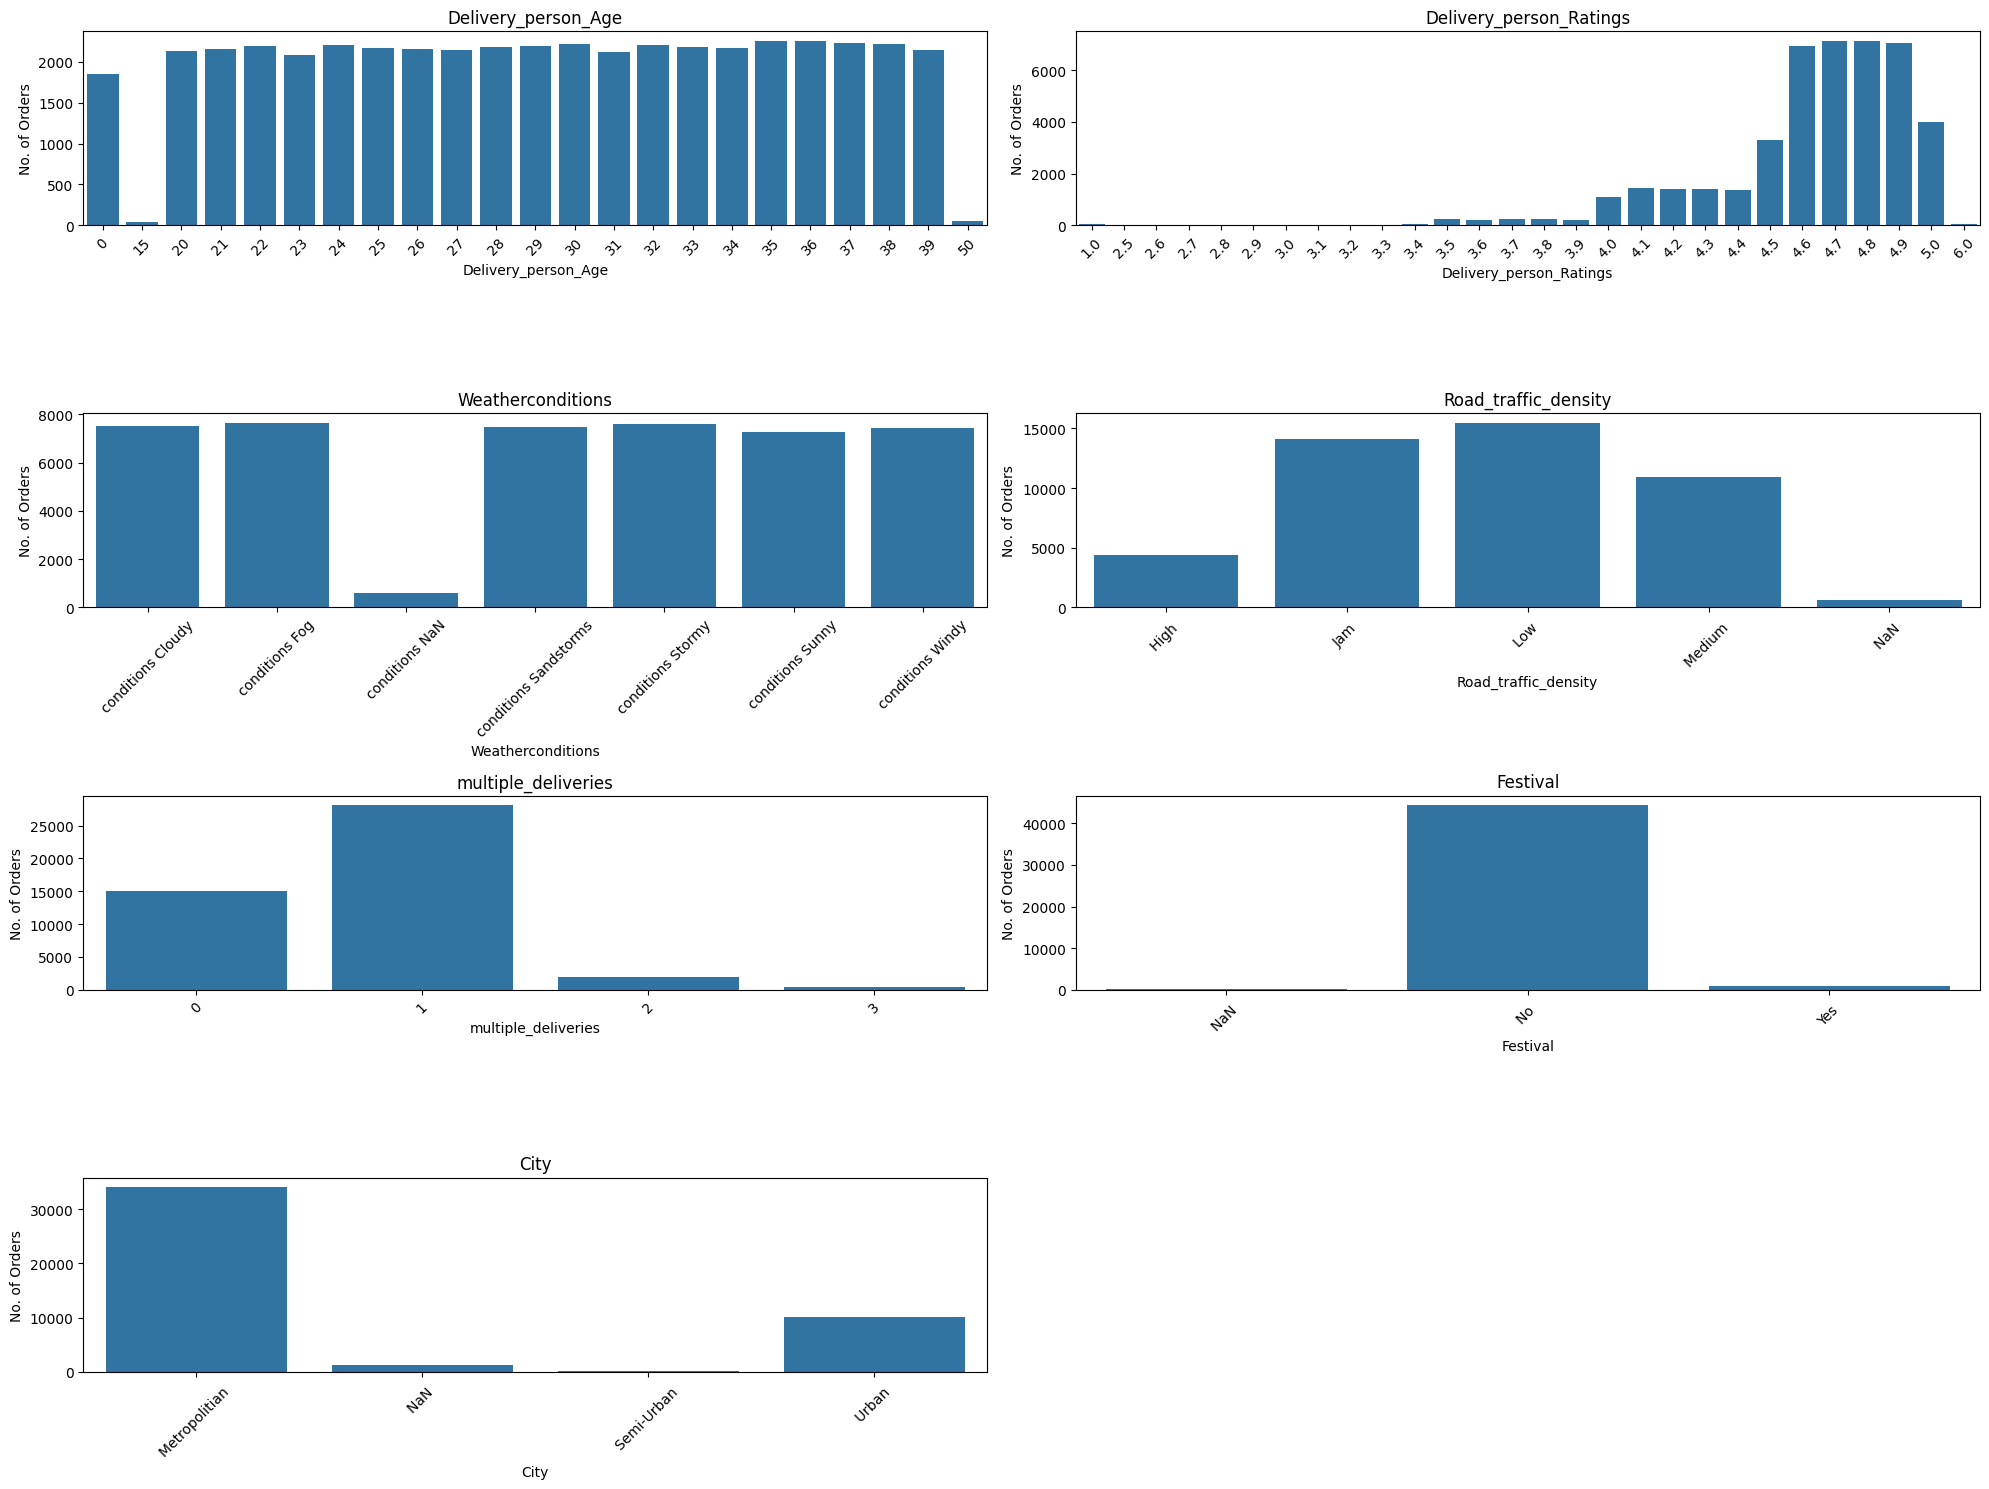

In [13]:
#Visualisating the distribution of the categorical variables:
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weatherconditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df.toPandas(), x=column_name, order=df.toPandas()[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)

if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [14]:
## Stripping all the white space present in categorical columns:
cat=[i for i in df.columns if df.select(i).dtypes[0][1] in ('string')]
for i in cat:
    df=df.withColumn(i,trim(df[i]))

In [15]:
## checking whether rows are trimmed:
df.toPandas().head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,2024-05-21 11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,2024-05-21 19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33


In [16]:
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weatherconditions','Road_traffic_density','multiple_deliveries','Festival','City']
for i in cols:
    ## Replacing the dataframe:
    df=df.withColumn(i,regexp_replace(i,"^(.*?)NaN","None"))

In [17]:
df.select(df.Weatherconditions).distinct().toPandas()

,Weatherconditions
0,None
1,conditions Sandstorms
2,conditions Fog
3,conditions Windy
4,conditions Sunny
5,conditions Cloudy
6,conditions Stormy


# <div style="color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:110%;font-family:Verdana;letter-spacing:0.5px"><p style="padding: 10px;color:white;">Feature Engineering Overview</p></div>
    
As observed from the above dataset, we can extract the following:

1. City from Delivery_person_ID ----> city

2. Bucket cities into Zones - North, South, East, West  ----> city_zone

3. Cleaning the Weatherconditions column

4. Removing Zero-Aged delivery agents

5. Time taken to process and package the delivery using Time_Orderd and Time_Order_picked ----> processing_time

6. Time of the day - Morning, Lunch, Evening, Night, Midnight ----> day_zone

7. To clean up target variable - Time_taken(min)

8. Bucket Age - Delivery_person_Age ----> life_stage

9. Features using Latitude and Longitude ----> geosidic

### <span style="background-color: #F3FF00;font-size: 35px">📌</span> There are three ways by which you can apply a custom function to rows of a spark dataframe:

- User Defined Functions
- Map functions
- Custom Spark-native functions

In [18]:
df.select("Weatherconditions").toPandas().head()

,Weatherconditions
0,conditions Sunny
1,conditions Stormy
2,conditions Sandstorms
3,conditions Sunny
4,conditions Cloudy


In [19]:
df.groupBy("Weatherconditions").count().sort(desc("count")).toPandas()

,Weatherconditions,count
0,conditions Fog,7654
1,conditions Stormy,7586
2,conditions Cloudy,7536
3,conditions Sandstorms,7495
4,conditions Windy,7422
5,conditions Sunny,7284
6,None,616


In [20]:
### list of unique weathers
weather=[i.__getitem__('Weatherconditions') for i in df.filter(df['Weatherconditions']!="None").select('Weatherconditions').distinct().collect()]
weather

['conditions Sandstorms',
 'conditions Fog',
 'conditions Windy',
 'conditions Sunny',
 'conditions Cloudy',
 'conditions Stormy']

In [21]:
df.select('Weatherconditions').toPandas()

,Weatherconditions
0,conditions Sunny
1,conditions Stormy
2,conditions Sandstorms
3,conditions Sunny
4,conditions Cloudy
...,...
45588,conditions Windy
45589,conditions Windy
45590,conditions Cloudy
45591,conditions Cloudy


In [22]:
## creating a copy:  ### For testing.
df2=df.alias('df2')

In [23]:
### Checking the working of the sample() method:
def random_weather(x):
    ind=np.random.randint(6)
    k=weather[ind]
    return k

## Creating a udf:
udf_random_weather=udf(lambda x:random_weather(x),StringType())

In [24]:
df=df.withColumn('Weatherconditions',when(df['Weatherconditions']=="None",udf_random_weather(df['Weatherconditions'])).otherwise(df['Weatherconditions']))

In [25]:
### Now we have successfully replaced the None with random values
df.groupBy('Weatherconditions').count().orderBy(desc('count')).toPandas()

,Weatherconditions,count
0,conditions Fog,7763
1,conditions Stormy,7698
2,conditions Cloudy,7638
3,conditions Sandstorms,7583
4,conditions Windy,7530
5,conditions Sunny,7381


In [26]:
## Around 4% of the delivery agents dont have an age:
df.filter(df["Delivery_person_Age"]==0).count()/df.count() * 100

4.066413703858048

In [27]:
## Seems to be that there is no correlation between 'Delivery_person_Age' and any other columns,
## apart from 'Time_Orderd', as viewed through naked eyes
df.filter(df["Delivery_person_Age"]==0).toPandas()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4f0,MUMRES17DEL02,0,None,19.121999,72.908493,19.201999,72.988493,06-04-2022,NaN,2024-05-21 18:35:00,conditions Cloudy,Medium,1,Drinks,scooter,1,No,Metropolitian,(min) 33
1,0xa9f,BANGRES13DEL01,0,None,12.935662,77.614130,12.975662,77.654130,11-03-2022,NaN,2024-05-21 15:30:00,conditions Windy,None,1,Drinks,scooter,0,No,Metropolitian,(min) 19
2,0x6e2,VADRES06DEL01,0,None,22.312790,73.170283,22.422790,73.280283,02-04-2022,NaN,2024-05-21 18:25:00,conditions Sunny,None,3,Snack,electric_scooter,0,No,Metropolitian,(min) 25
3,0x1ec7,PUNERES05DEL03,0,None,18.543626,73.905101,18.573626,73.935101,09-03-2022,NaN,2024-05-21 23:40:00,conditions Stormy,Low,2,Snack,scooter,0,No,None,(min) 19
4,0x1b58,JAPRES03DEL01,0,None,26.913483,75.803139,26.983483,75.873139,12-03-2022,NaN,2024-05-21 17:50:00,conditions Sandstorms,Medium,0,Drinks,motorcycle,0,No,Metropolitian,(min) 43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,0x426b,HYDRES06DEL01,0,None,17.455894,78.375467,17.525894,78.445467,23-03-2022,17:55:00,2024-05-21 18:00:00,conditions Fog,Medium,0,Meal,motorcycle,1,No,Urban,(min) 36
1850,0x863,INDORES05DEL01,0,None,22.727021,75.884167,22.737021,75.894167,19-03-2022,NaN,2024-05-21 11:40:00,conditions Cloudy,None,3,Snack,electric_scooter,0,No,Metropolitian,(min) 25
1851,0xd0be,AGRRES07DEL01,0,None,27.160934,78.044095,27.170934,78.054095,13-02-2022,NaN,2024-05-21 09:05:00,conditions Windy,None,3,Meal,electric_scooter,1,No,Urban,(min) 17
1852,0x1ed1,JAPRES18DEL01,0,None,26.913987,75.752891,27.023987,75.862891,27-03-2022,20:35:00,2024-05-21 20:45:00,conditions Cloudy,Jam,2,Snack,scooter,0,No,Metropolitian,(min) 48


In [28]:
## Removing them from the dataset:
df=df.filter(df["Delivery_person_Age"]!=0)

## Verifying counts:
df.count()
df.filter(df["Delivery_person_Age"]==0).count()

0

In [29]:
## There are order dates which are NaNs:
df.filter(df["Time_Orderd"]==np.NaN).count()

91

In [30]:
### As you can see, there are
df.filter(df["Time_Orderd"]==np.NaN).select(['Delivery_person_Age','Time_Orderd']).toPandas().head()

,Delivery_person_Age,Time_Orderd
0,15,NaN
1,15,NaN
2,15,NaN
3,50,NaN
4,50,NaN


In [31]:
df.filter(df["Time_Orderd"]==np.NaN).select(['Delivery_person_Age','Time_Orderd']).groupby(df['Delivery_person_Age']).count().orderBy(desc('count')).toPandas()

,Delivery_person_Age,count
0,50,53
1,15,38


#### - Analysing the **Time_Orderd** variable:

In [32]:
## Looks like there are ~1700 rows of null values in this column.
df.groupBy('Time_Orderd').count().sort(desc("count")).toPandas().head(10)
# df.groupBy('Time_Orderd').count().sort(col("count").desc()).select("Time_Orderd").show(1)  ### To view the NaN string

,Time_Orderd,count
0,21:55:00,460
1,17:55:00,453
2,22:20:00,446
3,20:00:00,446
4,21:35:00,445
5,19:50:00,444
6,21:15:00,437
7,21:20:00,437
8,22:45:00,435
9,18:10:00,435


In [33]:
df.filter(df['Time_Orderd']=="NaN").count()

91

#### - Analysing the **Order_Date** variable:

In [34]:
## There no null values here:
df.groupBy('Order_Date').count().sort(desc("count")).toPandas().head(10)

,Order_Date,count
0,15-03-2022,1141
1,03-04-2022,1133
2,13-03-2022,1123
3,26-03-2022,1119
4,03-03-2022,1119
5,09-03-2022,1117
6,24-03-2022,1112
7,05-03-2022,1112
8,21-03-2022,1107
9,05-04-2022,1106


In [35]:
df.filter(df['Order_Date']=="NaN").count()

0

In [36]:
df.select(['Order_Date','Time_Orderd']).toPandas().head(2)

,Order_Date,Time_Orderd
0,19-03-2022,11:30:00
1,25-03-2022,19:45:00


In [37]:
## Creating a udf without an explicit function, and using multiple columns with the help of struct function::
order_timestamp_udf = udf(lambda x: x[0]+" "+x[1], StringType())
df=df.withColumn("order_time_timestamp",order_timestamp_udf(struct('Order_Date','Time_Orderd')))#.select("order_time_timestamp")#.show(5)
## Viewing the created column:
df.select("order_time_timestamp").toPandas().head(2)

,order_time_timestamp
0,19-03-2022 11:30:00
1,25-03-2022 19:45:00


#### -  Analysing the **Time_Order_picked** variable:

In [38]:
df.groupBy('Time_Order_picked').count().sort(desc("count")).toPandas().head(10)

,Time_Order_picked,count
0,2024-05-21 21:30:00,481
1,2024-05-21 22:50:00,450
2,2024-05-21 21:45:00,445
3,2024-05-21 22:25:00,441
4,2024-05-21 17:55:00,440
5,2024-05-21 18:05:00,439
6,2024-05-21 23:50:00,438
7,2024-05-21 18:40:00,437
8,2024-05-21 22:40:00,437
9,2024-05-21 23:35:00,434


In [39]:
df.filter(df['Time_Orderd']=="NaN").count()

91

In [40]:
## selecting the Non-null rows
temp=df.filter(df['Time_Orderd']!="NaN").select(['Order_Date','Time_Orderd','order_time_timestamp'])\
            .withColumn('order_time_timestamp',to_timestamp('order_time_timestamp','dd-MM-yyyy HH:mm:ss'))
temp.toPandas().head()

,Order_Date,Time_Orderd,order_time_timestamp
0,19-03-2022,11:30:00,2022-03-19 11:30:00
1,25-03-2022,19:45:00,2022-03-25 19:45:00
2,19-03-2022,08:30:00,2022-03-19 08:30:00
3,05-04-2022,18:00:00,2022-04-05 18:00:00
4,26-03-2022,13:30:00,2022-03-26 13:30:00


In [41]:
### Now we have converted a string to a timestep
temp.dtypes

[('Order_Date', 'string'),
 ('Time_Orderd', 'string'),
 ('order_time_timestamp', 'timestamp')]

In [42]:
df.groupBy('order_time_timestamp').count().sort(desc("count")).toPandas().head()

,order_time_timestamp,count
0,20-03-2022 20:15:00,25
1,06-03-2022 18:35:00,24
2,02-03-2022 22:45:00,23
3,02-03-2022 17:55:00,22
4,10-03-2022 17:40:00,21


In [43]:
### Getting first row from the above table:
df.groupBy('order_time_timestamp').count().sort(desc("count")).collect()[:1][0].__getitem__('order_time_timestamp')

'20-03-2022 20:15:00'

In [44]:
## We remove the NaN filled order time from the existing data and treat them separately:
## To get the non-NaN containing timestamps:(There are two ways to do so.)
# df.filter(~df["order_time_timestamp"].like("%NaN%")).show(2)
temp=df.filter(~df["order_time_timestamp"].contains("NaN")).select(['order_time_timestamp','Time_Order_picked'])

In [45]:
temp.toPandas().head()

,order_time_timestamp,Time_Order_picked
0,19-03-2022 11:30:00,2024-05-21 11:45:00
1,25-03-2022 19:45:00,2024-05-21 19:50:00
2,19-03-2022 08:30:00,2024-05-21 08:45:00
3,05-04-2022 18:00:00,2024-05-21 18:10:00
4,26-03-2022 13:30:00,2024-05-21 13:45:00


In [46]:
temp.dtypes

[('order_time_timestamp', 'string'), ('Time_Order_picked', 'timestamp')]

In [47]:
## Converting datatype into timestamp:
temp=temp.withColumn('order_time_timestamp',to_timestamp(temp['order_time_timestamp'],'dd-MM-yyyy HH:mm:ss'))
temp.toPandas().head(2)

,order_time_timestamp,Time_Order_picked
0,2022-03-19 11:30:00,2024-05-21 11:45:00
1,2022-03-25 19:45:00,2024-05-21 19:50:00


In [48]:
temp = temp.withColumn('order_time', date_format('order_time_timestamp', 'HH:mm:ss'))\
           .withColumn('Time_picked', date_format('Time_Order_picked', 'HH:mm:ss'))

temp.toPandas().head(2)

,order_time_timestamp,Time_Order_picked,order_time,Time_picked
0,2022-03-19 11:30:00,2024-05-21 11:45:00,11:30:00,11:45:00
1,2022-03-25 19:45:00,2024-05-21 19:50:00,19:45:00,19:50:00


In [49]:
temp.dtypes

[('order_time_timestamp', 'timestamp'),
 ('Time_Order_picked', 'timestamp'),
 ('order_time', 'string'),
 ('Time_picked', 'string')]

In [50]:
### Calculating the difference in seconds, then dividing by 60 to get minutes
temp=temp.withColumn('order_time',to_timestamp(temp['order_time']))\
         .withColumn('Time_picked', to_timestamp(temp['Time_picked']))\
         .withColumn('processing_time',round((unix_timestamp("Time_picked") - unix_timestamp('order_time'))/60))

In [51]:
## Got the desired processing_time in minutes:
temp.toPandas().head()

,order_time_timestamp,Time_Order_picked,order_time,Time_picked,processing_time
0,2022-03-19 11:30:00,2024-05-21 11:45:00,2024-05-21 11:30:00,2024-05-21 11:45:00,15.0
1,2022-03-25 19:45:00,2024-05-21 19:50:00,2024-05-21 19:45:00,2024-05-21 19:50:00,5.0
2,2022-03-19 08:30:00,2024-05-21 08:45:00,2024-05-21 08:30:00,2024-05-21 08:45:00,15.0
3,2022-04-05 18:00:00,2024-05-21 18:10:00,2024-05-21 18:00:00,2024-05-21 18:10:00,10.0
4,2022-03-26 13:30:00,2024-05-21 13:45:00,2024-05-21 13:30:00,2024-05-21 13:45:00,15.0


In [52]:
## Replicating the above steps onto the actual dataframe:
df=df.withColumn('order_time_timestamp',to_timestamp(df['order_time_timestamp'],'dd-MM-yyyy HH:mm:ss'))\
     .withColumn('order_time', date_format('order_time_timestamp', 'HH:mm:ss'))\
     .withColumn('Time_picked', date_format('Time_Order_picked', 'HH:mm:ss'))\

df=df.withColumn('order_time',to_timestamp(df['order_time']))\
     .withColumn('Time_picked', to_timestamp(df['Time_picked']))

In [53]:
## Seems to be right so far
df.toPandas().head(1)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),order_time_timestamp,order_time,Time_picked
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,...,2,Snack,motorcycle,0,No,Urban,(min) 24,2022-03-19 11:30:00,2024-05-21 11:30:00,2024-05-21 11:45:00


In [54]:
### Creating a column called processing time:
df=df.withColumn('processing_time',when(df['Time_Orderd']!="NaN",round((unix_timestamp("Time_picked") - unix_timestamp('order_time'))/60))\
                                   .otherwise(lit(np.NaN)))

#### Checking whether columns are created properly:

In [55]:
df.filter(df['Time_Orderd']=="NaN").toPandas().head(3)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),order_time_timestamp,order_time,Time_picked,processing_time
0,0x564,JAPRES15DEL03,15,1.0,-26.891191,75.802083,26.981191,75.892083,12-03-2022,NaN,...,Meal,motorcycle,0,No,Urban,(min) 15,NaT,NaT,2024-05-21 17:20:00,NaN
1,0xcd0,INDORES010DEL03,15,1.0,22.750040,75.902847,22.810040,75.962847,03-04-2022,NaN,...,Snack,scooter,1,No,Metropolitian,(min) 29,NaT,NaT,2024-05-21 20:30:00,NaN
2,0x91a,SURRES17DEL03,15,1.0,21.149569,72.772697,21.209569,72.832697,21-03-2022,NaN,...,Buffet,bicycle,1,No,Metropolitian,(min) 20,NaT,NaT,2024-05-21 22:10:00,NaN


In [56]:
df.filter(df['Time_Orderd']!="NaN").toPandas().head(3)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),order_time_timestamp,order_time,Time_picked,processing_time
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,...,Snack,motorcycle,0,No,Urban,(min) 24,2022-03-19 11:30:00,2024-05-21 11:30:00,2024-05-21 11:45:00,15.0
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,...,Snack,scooter,1,No,Metropolitian,(min) 33,2022-03-25 19:45:00,2024-05-21 19:45:00,2024-05-21 19:50:00,5.0
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,...,Drinks,motorcycle,1,No,Urban,(min) 26,2022-03-19 08:30:00,2024-05-21 08:30:00,2024-05-21 08:45:00,15.0


Now we will replace these NaN values with the mean of the corresponding column:

In [57]:
df.filter(df['processing_time']<0).select(['order_time','Time_picked','processing_time']).toPandas()

,order_time,Time_picked,processing_time
0,2024-05-21 23:50:00,2024-05-21 00:05:00,-1425.0
1,2024-05-21 23:55:00,2024-05-21 00:10:00,-1425.0
2,2024-05-21 23:50:00,2024-05-21 00:00:00,-1430.0
3,2024-05-21 23:45:00,2024-05-21 00:00:00,-1425.0
4,2024-05-21 23:55:00,2024-05-21 00:10:00,-1425.0
...,...,...,...
823,2024-05-21 23:50:00,2024-05-21 00:00:00,-1430.0
824,2024-05-21 23:50:00,2024-05-21 00:05:00,-1425.0
825,2024-05-21 23:50:00,2024-05-21 00:05:00,-1425.0
826,2024-05-21 23:50:00,2024-05-21 00:00:00,-1430.0


In [58]:
## Looks like we have negative values. This can be because:
## 00:05 - 23:50 = -1425. Hence to correct these negative values, we add 1440(24*60):
df=df.withColumn('processing_time',when(df['processing_time']<0,df['processing_time']+1440).otherwise(df['processing_time']))
df.filter(df['processing_time']<0).select(['order_time','Time_picked','processing_time']).toPandas()

,order_time,Time_picked,processing_time


In [59]:
## The processing time taken by the restaurant is::
mean_processing=df.filter(df['Time_Orderd']!="NaN").select(mean("processing_time")).collect()[0].__getitem__('avg(processing_time)')
mean_processing

9.991293988269796

In [60]:
## Takes column name as parameter:
df=df.na.fill(mean_processing,'processing_time')

#### As we can see from below, we have got our final output:

In [61]:
df.filter(df['Time_Orderd']=="NaN").select(['order_time','Time_picked','processing_time']).toPandas()

,order_time,Time_picked,processing_time
0,NaT,2024-05-21 17:20:00,9.991294
1,NaT,2024-05-21 20:30:00,9.991294
2,NaT,2024-05-21 22:10:00,9.991294
3,NaT,2024-05-21 12:30:00,9.991294
4,NaT,2024-05-21 23:20:00,9.991294
...,...,...,...
86,NaT,2024-05-21 20:40:00,9.991294
87,NaT,2024-05-21 09:40:00,9.991294
88,NaT,2024-05-21 17:40:00,9.991294
89,NaT,2024-05-21 18:00:00,9.991294


<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">Splitting the time of ordering into zones of a day - Morning, Lunch, Evening, Night, Midnight:</p></blockquote>

In [62]:
## All the available Datetime columns:
df.select(['Order_Date','Time_Orderd','order_time','order_time_timestamp','Time_picked','Time_Order_picked']).toPandas()

,Order_Date,Time_Orderd,order_time,order_time_timestamp,Time_picked,Time_Order_picked
0,19-03-2022,11:30:00,2024-05-21 11:30:00,2022-03-19 11:30:00,2024-05-21 11:45:00,2024-05-21 11:45:00
1,25-03-2022,19:45:00,2024-05-21 19:45:00,2022-03-25 19:45:00,2024-05-21 19:50:00,2024-05-21 19:50:00
2,19-03-2022,08:30:00,2024-05-21 08:30:00,2022-03-19 08:30:00,2024-05-21 08:45:00,2024-05-21 08:45:00
3,05-04-2022,18:00:00,2024-05-21 18:00:00,2022-04-05 18:00:00,2024-05-21 18:10:00,2024-05-21 18:10:00
4,26-03-2022,13:30:00,2024-05-21 13:30:00,2022-03-26 13:30:00,2024-05-21 13:45:00,2024-05-21 13:45:00
...,...,...,...,...,...,...
43734,24-03-2022,11:35:00,2024-05-21 11:35:00,2022-03-24 11:35:00,2024-05-21 11:45:00,2024-05-21 11:45:00
43735,16-02-2022,19:55:00,2024-05-21 19:55:00,2022-02-16 19:55:00,2024-05-21 20:10:00,2024-05-21 20:10:00
43736,11-03-2022,23:50:00,2024-05-21 23:50:00,2022-03-11 23:50:00,2024-05-21 00:05:00,2024-05-21 00:05:00
43737,07-03-2022,13:35:00,2024-05-21 13:35:00,2022-03-07 13:35:00,2024-05-21 13:40:00,2024-05-21 13:40:00


#### We will use the Time_picked column for the preprocessing as Time_Orderd contains Null Values:

In [63]:
## No null values:
df.filter(df['Time_picked']==None).toPandas().head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),order_time_timestamp,order_time,Time_picked,processing_time


In [64]:
## The Time_picked is a timestamp:
df.select('Time_picked').toPandas().head(5)

,Time_picked
0,2024-05-21 11:45:00
1,2024-05-21 19:50:00
2,2024-05-21 08:45:00
3,2024-05-21 18:10:00
4,2024-05-21 13:45:00


#### So from the above timestamp column, we try to isolate hour:

In [65]:
df=df.withColumn('hour_picked',hour(df['Time_picked']))
df.select(['Time_picked','hour_picked']).toPandas().head()

,Time_picked,hour_picked
0,2024-05-21 11:45:00,11
1,2024-05-21 19:50:00,19
2,2024-05-21 08:45:00,8
3,2024-05-21 18:10:00,18
4,2024-05-21 13:45:00,13


#### Below, we define a function to classify the hours into day-zones.

In [66]:
def time_of_day(x):
    if x in [4,5,6,7,8,9,10]:
        return "Morning"
    elif x in [11,12,13,14,15]:
        return "Afternoon"
    elif x in [16,17,18,19]:
        return "Evening"
    elif x in [20,21,22,23]:
        return "Night"
    else:
        return "Midnight"

time_day_udf=udf(time_of_day,StringType())
df=df.withColumn('day_zone',time_day_udf(df["hour_picked"]))
df.select(['hour_picked','day_zone']).toPandas().head()

,hour_picked,day_zone
0,11,Afternoon
1,19,Evening
2,8,Morning
3,18,Evening
4,13,Afternoon


<blockquote><p style="font-size:20px; color:#159364; background-color: #FFFF00; font-family:verdana;">Cleaning the target variable:</p></blockquote>

In [67]:
## Before transformation:
df.select("Time_taken(min)").toPandas().head()

,Time_taken(min)
0,(min) 24
1,(min) 33
2,(min) 26
3,(min) 21
4,(min) 30


In [68]:
## Renaming the column name::
df=df.withColumnRenamed('Time_taken(min)','time_taken')

## Removing the preffix (i.e. '(min)') in the column values with the help of a UDF:
def target_clean(x):
    return int(x[-2:])

target_clean_udf=udf(lambda x:target_clean(x),IntegerType())
## Cleaning and Converting type to integer:
df=df.withColumn("time_taken",target_clean_udf(df["time_taken"]))

In [69]:
df.select('time_taken').toPandas().head()

,time_taken
0,24
1,33
2,26
3,21
4,30


<blockquote><p style="font-size:20px; color:#159364; background-color: #FFFF00; font-family:verdana;">Bucketing age of delivery agents:</p></blockquote>

In [70]:
df.select(['Delivery_person_Age']).distinct().toPandas()

,Delivery_person_Age
0,15
1,29
2,30
3,34
4,22
5,28
6,35
7,31
8,27
9,26


In [71]:
df.groupBy('Delivery_person_Age').count().orderBy(df['Delivery_person_Age'].asc()).toPandas()

,Delivery_person_Age,count
0,15,38
1,20,2136
2,21,2153
3,22,2196
4,23,2087
5,24,2210
6,25,2174
7,26,2159
8,27,2150
9,28,2179


#### Deliver Age of 15 and 50 seems to be suspicious. They seem to behave like outliers. We keep them though.

In [72]:
## Defining a udf:
def age_bucket(x):
    if int(x) in range(15,31):
        return "Youth driver"
    elif int(x) in range(30,50):
        return "Adult driver"
    else:
      return "Adult driver"

age_bucket_udf=udf(age_bucket,StringType())
df=df.withColumn('age_bucket',age_bucket_udf(df["Delivery_person_Age"]))
df.select(['Delivery_person_Age','age_bucket']).toPandas().head()

,Delivery_person_Age,age_bucket
0,37,Adult driver
1,34,Adult driver
2,23,Youth driver
3,38,Adult driver
4,32,Adult driver


In [73]:
df.select(df['Delivery_person_Ratings']).filter(df['Delivery_person_Ratings'] == "None").count()

54

In [74]:
mean_rating = df.select(mean(df["Delivery_person_Ratings"])).collect()[0][0]
df = df.withColumn("Delivery_person_Ratings",
                           when((df["Delivery_person_Ratings"]) == 'None', mean_rating).otherwise(df["Delivery_person_Ratings"]))

In [75]:
## Defining a udf:
def rating_bucket(x):
    if float(x) in range(0,2):
        return "Low rating"
    elif float(x) in range(2,3):
        return "Medium rating"
    elif float(x) in range(3,4):
      return "High rating"
    else:
      return "Very high rating"

rating_bucket_udf=udf(rating_bucket,StringType())
df=df.withColumn('rating_bucket',rating_bucket_udf(df["Delivery_person_Ratings"]))
df.select(['Delivery_person_Ratings','rating_bucket']).toPandas().head()

,Delivery_person_Ratings,rating_bucket
0,4.9,Very high rating
1,4.5,Very high rating
2,4.4,Very high rating
3,4.7,Very high rating
4,4.6,Very high rating


In [76]:
df.filter(df['Delivery_person_Ratings'] == "None").count()

0

In [77]:
df.filter(df['Road_traffic_density'] == "None").count()

91

In [78]:
non_null_values = [row[0] for row in df.select(df["Road_traffic_density"]).distinct().collect()]
if "None" in non_null_values:
  non_null_values.remove('None')
if None in non_null_values:
  non_null_values.remove(None)
print(non_null_values)

['High', 'Low', 'Medium', 'Jam']


In [79]:
def random_choice():
    return random.choice(non_null_values)

random_choice_udf = udf(random_choice, StringType())

df = df.withColumn("Road_traffic_density",
                           when((df["Road_traffic_density"])=='None', random_choice_udf()).otherwise(df["Road_traffic_density"]))

df = df.withColumn("Road_traffic_density", concat(df["Road_traffic_density"], lit(" traffic")))

In [80]:
df.filter(df['Road_traffic_density'] == "None").count()

0

<blockquote><p style="font-size:20px; color:#159364; background-color: #FFFF00; font-family:verdana;">Handling the Geo Data:</p></blockquote>

### **GeoPy** is a Python library that makes geographical calculations easier for the users. There are two ways to calculate distance between two points:

#### 1. Assuming that the Earth is a flat land and calculating distance.

#### 2. Assuming that the Earth is spherical and calculating distance.

In [81]:
from geopy.distance import geodesic

## We define this function:

def geo_distance(src_lat,src_long,des_lat,des_long):
    ## initialising the source and destination coordinates:
    src_coordinates=(src_lat,src_long)
    des_coordinates=(des_lat,des_long)
    return geodesic(src_coordinates, des_coordinates).km   ### km method converts the distance into kms

## Creating a udf:
geosidic_distance_udf=udf(lambda x:geo_distance(x[0],x[1],x[2],x[3]),FloatType())

In [82]:
## Check if any negative coordinates
df.select('Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude').filter(
    (df["Restaurant_latitude"] < 0) |
    (df["Restaurant_longitude"] < 0) |
    (df["Delivery_location_latitude"] < 0) |
    (df["Delivery_location_longitude"] < 0)
).count()

188

In [83]:
df = df.withColumn("Restaurant_latitude", abs(df["Restaurant_latitude"])) \
               .withColumn("Restaurant_longitude", abs(df["Restaurant_longitude"])) \
               .withColumn("Delivery_location_latitude", abs(df["Delivery_location_latitude"])) \
               .withColumn("Delivery_location_longitude", abs(df["Delivery_location_longitude"]))

In [84]:
## Remember we had seen that struct() is used to pass multiple columns into udf:
df = df.withColumn("src_des_distance_kms",geosidic_distance_udf(struct('Restaurant_latitude','Restaurant_longitude',\
                                                       'Delivery_location_latitude','Delivery_location_longitude')))
df.select('src_des_distance_kms').toPandas().head()

,src_des_distance_kms
0,3.020737
1,20.143738
2,1.549693
3,7.774497
4,6.197898


In [85]:
df = df.withColumn("avg_velocity_km/hr",df['src_des_distance_kms']/(df['time_taken']/60))
df.select('src_des_distance_kms','time_taken','avg_velocity_km/hr').orderBy(df['avg_velocity_km/hr'].desc()).toPandas().head()

,src_des_distance_kms,time_taken,avg_velocity_km/hr
0,20.829460,10,124.976761
1,20.827572,10,124.965431
2,20.823996,10,124.943974
3,20.807497,10,124.844982
4,20.397442,10,122.384651


In [86]:
df.select('src_des_distance_kms','time_taken','avg_velocity_km/hr','Road_traffic_density').orderBy(df['avg_velocity_km/hr'].asc()).toPandas().head()

,src_des_distance_kms,time_taken,avg_velocity_km/hr,Road_traffic_density
0,1.496237,53,1.693853,High traffic
1,1.488048,49,1.822099,High traffic
2,1.488175,49,1.822256,High traffic
3,1.507237,49,1.845596,High traffic
4,1.510477,49,1.849564,High traffic


In [87]:
def delivery_bucket(x):
    if int(x) in range(0,30):
        return "Slow delivery"
    elif int(x) in range(30,60):
        return "Medium delivery"
    elif int(x) in range(60,90):
      return "Fast delivery"
    else:
      return "Very fast delivery"

delivery_bucket_udf=udf(delivery_bucket,StringType())
df = df.withColumn('delivery_bucket',delivery_bucket_udf(df["avg_velocity_km/hr"]))

df.groupBy('delivery_bucket').count().orderBy(df['delivery_bucket'].asc()).toPandas()

,delivery_bucket,count
0,Fast delivery,1281
1,Medium delivery,10507
2,Slow delivery,31794
3,Very fast delivery,157


In [88]:
def vehicle_condition_bucket(x):
    if int(x)==0:
        return "Very bad vehicle"
    elif int(x)==1:
        return "Bad vehicle"
    elif int(x)==2:
      return "Good vehicle"
    elif int(x)==3:
      return "Very good vehicle"

vehicle_condition_bucket_udf=udf(vehicle_condition_bucket,StringType())
df = df.withColumn('Vehicle_condition_bucket',vehicle_condition_bucket_udf(df["Vehicle_condition"]))

df.groupBy('Vehicle_condition_bucket').count().orderBy(df['Vehicle_condition_bucket'].asc()).toPandas()

,Vehicle_condition_bucket,count
0,Bad vehicle,14535
1,Good vehicle,14569
2,Very bad vehicle,14544
3,Very good vehicle,91


In [89]:
df.columns

['ID',
 'Delivery_person_ID',
 'Delivery_person_Age',
 'Delivery_person_Ratings',
 'Restaurant_latitude',
 'Restaurant_longitude',
 'Delivery_location_latitude',
 'Delivery_location_longitude',
 'Order_Date',
 'Time_Orderd',
 'Time_Order_picked',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'Type_of_order',
 'Type_of_vehicle',
 'multiple_deliveries',
 'Festival',
 'City',
 'time_taken',
 'order_time_timestamp',
 'order_time',
 'Time_picked',
 'processing_time',
 'hour_picked',
 'day_zone',
 'age_bucket',
 'rating_bucket',
 'src_des_distance_kms',
 'avg_velocity_km/hr',
 'delivery_bucket',
 'Vehicle_condition_bucket']

## FP-Growth and Association rules

In [91]:
import numpy as np
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from pyspark.sql.functions import col, expr
from pyspark.ml.fpm import FPGrowth

c_df = df.select('age_bucket','day_zone','Road_traffic_density','Weatherconditions','Vehicle_condition_bucket','Type_of_order','delivery_bucket')
p_df = c_df.toPandas()
pd_array = p_df.to_numpy()

array = [list(transaction) if isinstance(transaction, np.ndarray) else transaction for transaction in pd_array]

schema = StructType([
    StructField("items", ArrayType(StringType()), nullable=False)
])

transactions = [Row(items=transaction) for transaction in array]

transactions_df = spark.createDataFrame(transactions, schema)

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.17, minConfidence=0.7)
model = fpGrowth.fit(transactions_df)

frequent_itemsets = model.freqItemsets
frequent_itemsets_filtered = frequent_itemsets.filter(col("freq") / transactions_df.count() >= 0.7)

rules = model.associationRules

desired_consequent = {"Slow delivery"}
filtered_rules = rules.filter(expr("array_contains(consequent, 'Slow delivery')"))

filtered_rules.toPandas()

,antecedent,consequent,confidence,lift,support
0,[Jam traffic],[Slow delivery],0.735686,1.012083,0.231190
1,[Drinks],[Slow delivery],0.723878,0.995839,0.179931
2,[Buffet],[Slow delivery],0.727718,1.001121,0.180137
3,[Very bad vehicle],[Slow delivery],0.815113,1.121350,0.271040
4,[Meal],[Slow delivery],0.732544,1.007761,0.183978
5,[Adult driver],[Slow delivery],0.812702,1.118033,0.368641
6,[Snack],[Slow delivery],0.723474,0.995282,0.182857
7,"[Jam traffic, Night]",[Slow delivery],0.736348,1.012994,0.175724


In [92]:
filtered_rules_lift_gt_1 = filtered_rules.filter(expr("lift > 1.01"))
filtered_rules_lift_gt_1.toPandas()

,antecedent,consequent,confidence,lift,support
0,[Jam traffic],[Slow delivery],0.735686,1.012083,0.231190
1,[Very bad vehicle],[Slow delivery],0.815113,1.121350,0.271040
2,[Adult driver],[Slow delivery],0.812702,1.118033,0.368641
3,"[Jam traffic, Night]",[Slow delivery],0.736348,1.012994,0.175724


## Delivery Time Prediction using PySpark MLlib Random forest

In [93]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

m_df = df.select('Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions',
                 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
                 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
                 'time_taken', 'src_des_distance_kms')

m_df=m_df.withColumn('Delivery_person_Age',col('Delivery_person_Age').cast(FloatType()))\
.withColumn('src_des_distance_kms',col('src_des_distance_kms').cast(FloatType()))\
.withColumn('time_taken',col('time_taken').cast(FloatType()))\
.withColumn('Vehicle_condition',col('Vehicle_condition').cast(FloatType()))\
.withColumn('Delivery_person_Ratings',col('Delivery_person_Ratings').cast(FloatType()))

imputer = Imputer(inputCols=['Delivery_person_Age', 'Delivery_person_Ratings',
                             'Vehicle_condition', 'src_des_distance_kms'],
                  outputCols=['Delivery_person_Age', 'Delivery_person_Ratings',
                              'Vehicle_condition', 'src_des_distance_kms'])

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in
            ['Weatherconditions', 'Road_traffic_density', 'Type_of_order',
             'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City']]

encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in
            ['Weatherconditions', 'Road_traffic_density', 'Type_of_order',
             'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City']]

assembler = VectorAssembler(inputCols=['Delivery_person_Age', 'Delivery_person_Ratings',
                                       'Vehicle_condition', 'src_des_distance_kms'] +
                                      [col+"_encoded" for col in
                                       ['Weatherconditions', 'Road_traffic_density',
                                        'Type_of_order', 'Type_of_vehicle',
                                        'multiple_deliveries', 'Festival', 'City']],
                            outputCol='features')

scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=False)

rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='time_taken', numTrees=100, maxDepth=10)

pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, scaler, rf])

train_data, test_data = m_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='time_taken', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)
print(f'R2 score: {r2}')

evaluator = RegressionEvaluator(labelCol='time_taken', predictionCol='prediction', metricName='mae')
mae = evaluator.evaluate(predictions)
print(f'MAE: {mae}')

evaluator = RegressionEvaluator(labelCol='time_taken', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)
print(f'MSE: {mse}')

rmse = mse ** 0.5
print(f'RMSE: {rmse}')

R2 score: 0.7873376400237407
MAE: 3.422917957590268
MSE: 18.60988187217335
RMSE: 4.313917230565898


In [95]:
results = predictions.select('time_taken', 'prediction')

results.toPandas()

,time_taken,prediction
0,29.0,27.552490
1,27.0,29.051829
2,27.0,26.200745
3,24.0,25.160464
4,21.0,26.091338
...,...,...
8691,16.0,21.461249
8692,24.0,24.137011
8693,33.0,36.398316
8694,48.0,40.818552
